# Function 

In [6]:
from numba import jit
import cvxpy as cp

def beamforming_multi(f=6000,snapshots=1000,SNR=10,Noise=True,Denoise=True,diagonal_remove=False,source="line",plot=True): 
  global CSM_image
  t=time.time()
  #settings for acoustic source and algorithm
  c=340
  k=2*np.pi*f/c# num of wave
  M=pos.shape[0]
  K=5
  if source=="line":
    source=[[0,i,1] for i in np.linspace(0.5,-0.5,K)]
  if source=="single":
    source=[[0.2,0.2,1]]
  if source=="double":
    source=[[0.2,0.2,1],[-0.2,-0.2,1]]
  if source=="five":
    source=[[-0.2,-0.2,1],[0.2,0.2,1],[-0.2,0.2,1],[0.2,-0.2,1],[0,0,1]]
  K=np.array(source).shape[0]

  @jit(nopython=True)
  def vr(r,phase):
      vr=np.exp(-1j*(k*np.linalg.norm(r)+phase))/(4*np.pi*np.linalg.norm(r))
      return vr

  depth=1
  hmp=101**2#how many points to search .this num should be set square feet of an interger
  search= np.zeros([hmp,3])
  sqrt_s=int(np.sqrt(hmp))#sqrt_s
  search_x = np.linspace(-0.5, 0.5, sqrt_s)
  search_y = np.linspace(-0.5, 0.5, sqrt_s)
  for i in range(sqrt_s):
      search[i*sqrt_s:(i+1)*sqrt_s,0]=search_x[i]
      for j in range(sqrt_s):
          search[i*sqrt_s+j,1]=search_y[j]
  search[:,2]=depth

  inputs=100 #dB
  a=10**(inputs/10)

  #noise added on p
  @jit(nopython=True)
  def noise(p):
    p_real=np.real(p)
    p_imag=np.imag(p)
    n_real=p_real*np.sqrt(10**(-SNR/10))
    n_imag=p_imag*np.sqrt(10**(-SNR/10))

    noise_real= np.random.randn() * n_real  
    noise_imag= np.random.randn() * n_imag
    noise=noise_real+1j*noise_imag
    return noise
 
  Saa=0+0j
  for i in range(snapshots):
    current_Saa=0+0j
    for j in range(len(source)):
        real_p=[]#real pressure signal without p0  
        phase=np.random.rand()*np.pi*2
        for m in range(M):         
            current_rp=np.sqrt(a)*vr(pos[m]-np.array([source[j][0],source[j][1],source[j][2]]),phase)
            real_p.append(current_rp)  
        real_p=np.array([real_p])
        current_Saa+=np.dot(np.transpose(real_p),real_p.conjugate())
    
    
    Saa+=current_Saa
  Saa=Saa/snapshots

  Spp=0+0j
  for i in range(snapshots):
    current_Spp=0+0j
    for j in range(len(source)):
        real_p=[]#real pressure signal without p0  
        phase=np.random.rand()*np.pi*2
        for m in range(M):         
            current_rp=np.sqrt(a)*vr(pos[m]-np.array([source[j][0],source[j][1],source[j][2]]),phase)
            current_rp+=noise(current_rp)
            real_p.append(current_rp)  
        real_p=np.array([real_p])
        current_Spp+=np.dot(np.transpose(real_p),real_p.conjugate())
     
    Spp+=current_Spp
  
  Spp=Spp/snapshots

  if Noise==True: 
    Spp=Spp
  if Noise==False:
    Spp=Saa


#denoise
  if Denoise==True:
    row, col = np.diag_indices_from(Spp);Spp[row,col] = 0
    x = cp.Variable(M)# x represents sigmaq**2
    objective = cp.Minimize(cp.norm(x,1))
    constraints = [Spp+cp.atoms.affine.diag.diag(x)>>0]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver="SCS")
    Spp=Spp+cp.atoms.affine.diag.diag(x).value

  if diagonal_remove==True:
    row, col = np.diag_indices_from(Spp);Spp[row,col] = 0 #set diagonal values to 0

  spp= Spp.flatten()    

  csm_im = np.zeros([hmp])
  
  for i in range(hmp):
      fake_p=[]#fake pressure signal without p0
      for m in range(M):
          current_fp=vr(pos[m]-search[i],0)
          fake_p.append(current_fp)
      fake_p=np.array([fake_p]);

      h=np.dot(np.transpose(fake_p),fake_p.conjugate())
      if diagonal_remove==True:
        row, col = np.diag_indices_from(h); h[row,col] = 0#set diagonal values to 0
      h=h.flatten()

      csm_im[i]=np.real(np.dot(np.transpose(h.conjugate()),spp)/np.dot(np.transpose(h.conjugate()),h))
  CSM_image=np.zeros([sqrt_s,sqrt_s])
  
  for i in range(sqrt_s):
      CSM_image[i,:]=csm_im[sqrt_s*i:sqrt_s*(i+1)]

  threshold=np.max(CSM_image)/10**1.5
  CSM_image[CSM_image<=threshold]=np.nan
  CSM_image=10*np.log(CSM_image)/np.log(10)

  CSM_image=np.transpose(CSM_image)
  CSM_image=np.flipud(CSM_image)
  if plot==True:
    plt.figure()
    plt.title("Maximum=%.2f"%np.max(CSM_image[CSM_image>0])+"dB")
    vmax=np.round(np.max(CSM_image[CSM_image>0]),3)
    vmin=vmax-15
    plt.imshow(CSM_image,vmax=vmax,vmin=vmin,cmap="jet")
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xticks([0,50,100],[-0.5,0,0.5])
    plt.yticks([0,50,100],[0.5,0,-0.5])
  if Noise==True:
    numerator=Saa-Spp;  numerator=cp.atoms.affine.diag.diag(numerator).value
    denominator=Saa;  denominator=cp.atoms.affine.diag.diag(denominator).value
    delta= np.linalg.norm(numerator)/np.linalg.norm(denominator)
    delta=10*np.log(delta)/np.log(10)
    return delta

# Different Microphones Arrays and Corresponding Simulation WITHOUT NOISE

## 6*6 Rectangle Micros Array

how many micros 36


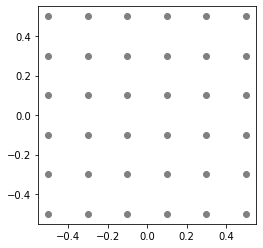

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

#settings for microphone
M=6**2# this num should be set square feet of an interger
sqrt_M=int(np.sqrt(M))
pos= np.zeros([M,3])
pos_x = np.linspace(-0.5, 0.5, sqrt_M)
pos_y = np.linspace(-0.5, 0.5, sqrt_M)
for i in range(sqrt_M):
    pos[i*sqrt_M:(i+1)*sqrt_M,0]=pos_x[i]
    for j in range(sqrt_M):
        pos[i*sqrt_M+j,1]=pos_y[j]

plt.figure(1)
#plt.title("microphones")
plt.scatter(pos[:,0],pos[:,1],color="gray")
plt.axis('scaled')
print("how many micros",pos.shape[0])

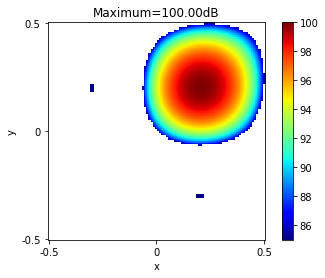

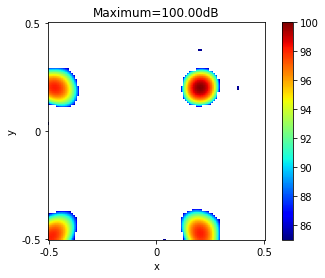

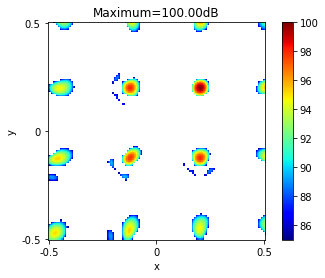

In [7]:
for i in [1000,3000,6000]:
    beamforming_multi(f=i,snapshots=1,SNR=-10,Noise=False,Denoise=False,diagonal_remove=True,source="single")
#Source number can be changed to 2 or more by using different "sourse" argument

## 10*10 Rectangle Micros Array

how many micros 100


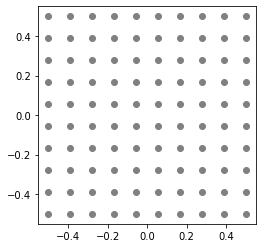

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import time

#settings for microphone
M=10**2# this num should be set square feet of an interger
sqrt_M=int(np.sqrt(M))
pos= np.zeros([M,3])
pos_x = np.linspace(-0.5, 0.5, sqrt_M)
pos_y = np.linspace(-0.5, 0.5, sqrt_M)
for i in range(sqrt_M):
    pos[i*sqrt_M:(i+1)*sqrt_M,0]=pos_x[i]
    for j in range(sqrt_M):
        pos[i*sqrt_M+j,1]=pos_y[j]

plt.figure(1)
#plt.title("microphones")
plt.scatter(pos[:,0],pos[:,1],color="gray")
plt.axis('scaled')
print("how many micros",pos.shape[0])

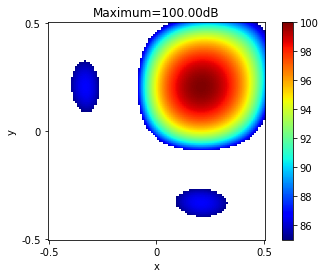

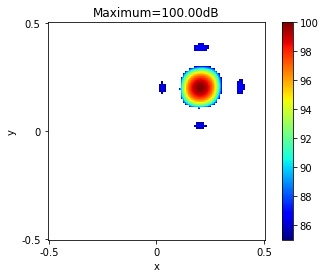

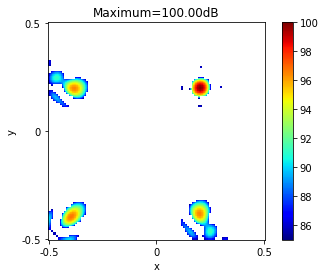

In [9]:
for i in [1000,3000,6000]:
    beamforming_multi(f=i,snapshots=1,SNR=-10,Noise=False,Denoise=False,diagonal_remove=True,source="single")

## Circle Micros Array

0.013937711715698242


(36, 3)

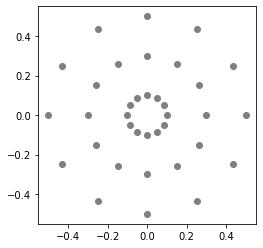

In [10]:
t=time.time()
#settings for microphone
M=36
sqrt_M=int(np.sqrt(M))

nmicro = M #16 microphones in total
R = [0.1,0.3,0.5]
layers = len(R)
micros_every_layer = nmicro//layers #integer remained only

#obtain theta vector for all micros
theta_micro = np.zeros(nmicro)
for layer in range(layers):#np.arange() generates a vector range from 0 to (input number-1)
    theta_micro[micros_every_layer*layer:micros_every_layer*(layer+1)] =2*np.pi/micros_every_layer*(np.arange(micros_every_layer))

#obtain position of all microphones, concatenate pieces these array together without changing shape, while np.stack changes shape, adding 1 new dimension
pos=np.zeros([1,2])
for i in range(layers):
    tem_pos=np.stack([R[i] * np.cos(theta_micro[micros_every_layer*i:micros_every_layer*(i+1)]), R[i] * np.sin(theta_micro[micros_every_layer*i:micros_every_layer*(i+1)])],axis = 1)
    pos=np.concatenate((pos,tem_pos),axis=0)
pos=pos[1:,:]#delete first row
pos_new=np.zeros([M,3])
pos_new[:,:2]=pos
pos=pos_new
plt.figure(1)
#plt.title("microphones")
plt.scatter(pos[:,0],pos[:,1],c="gray")
plt.axis('scaled')
t=time.time()-t
print(t)

pos.shape

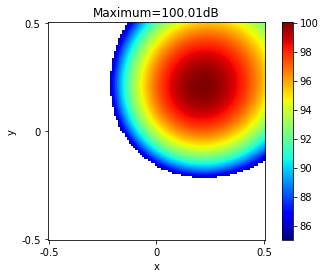

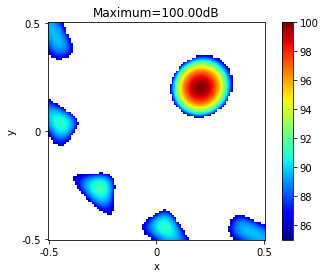

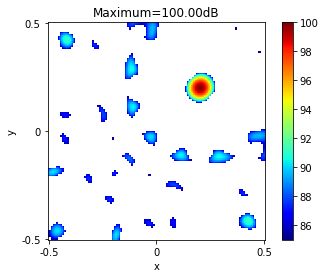

In [11]:
for i in [1000,3000,6000]:
    beamforming_multi(f=i,snapshots=1,SNR=-10,Noise=False,Denoise=False,diagonal_remove=True,source="single")

## Wheel Micros Array

0.014994621276855469
how many micros 42


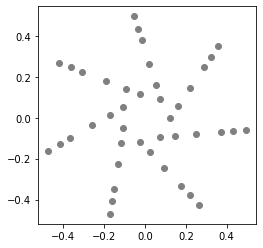

In [13]:
import numpy as np;import matplotlib.pyplot as plt;import time;
t=time.time()
M=42
R=0.5

phi=56/180*np.pi;r=0.12;
d=r*np.sin(phi)
l=np.sqrt(R**2-d**2)-np.sqrt(r**2-d**2)
l1=0.17*l;l2=0.25*l;l3=0.29*l;l4=0.14*l;l5=(1-0.17-0.25-0.29-0.14)*l
L=np.array([l1,l2,l3,l4,l5])

phi=56/180*np.pi

#print(np.tan(-np.pi/2+phi))
#print(d)
#y=-0.67x; x**2+y**2=d**2
x0=np.sqrt(d**2/(1+np.tan(-np.pi/2+phi)**2))
y0=np.tan(-np.pi/2+phi)*x0
#print(x0,y0)
#y-y0=k(x-x0)
k=np.tan(phi)
b=y0-k*x0
#print("k",k,"b",y0-k*x0)#y=kx+b; x**2+y**2=r**2
a=k**2+1;B=2*k*b;c=b**2-r**2
delta=B**2-4*a*c;#print("delta",delta)
x_l1=(-B+np.sqrt(delta))/(2*a);y_l1=k*x_l1+b
#print(x_l1,y_l1)
theta=np.arctan(y_l1/x_l1)
#print(theta)

'''''''''
x_l1=r*np.cos(phi)
y_l1=r*np.sin(phi)
'''''''''

l1x=[x_l1];l1y=[y_l1]
#theta=phi
for i in range(1,7):
    theta=theta+360/7/180*np.pi
    l1x.append(r*np.cos(theta))
    l1y.append(r*np.sin(theta))

#print(l1x)
#print(l1y)

pos_x=[]
pos_y=[]
for i in range(7):
    angle=phi+i*360/7/180*np.pi
    pos_x.append(l1x[i])
    pos_y.append(l1y[i])
    coordinate_x=l1x[i]
    coordinate_y=l1y[i]
    for j in range(5):
        coordinate_x+=L[j]*np.cos(angle)
        pos_x.append(coordinate_x)
        coordinate_y+=L[j]*np.sin(angle)
        pos_y.append(coordinate_y)
    

    
pos_x=np.array(pos_x);pos_y=np.array(pos_y)
plt.scatter(pos_x,pos_y,c="gray")
plt.axis('scaled')
pos= np.zeros([pos_x.shape[0],3])
pos[:,0]=pos_x
pos[:,1]=pos_y

t=time.time()-t
print(t)
print("how many micros",pos.shape[0])

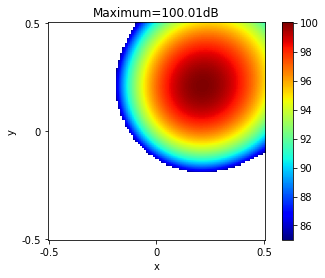

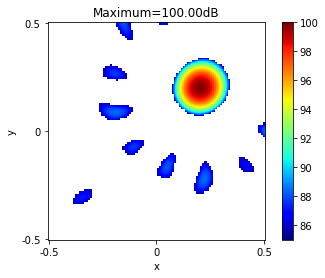

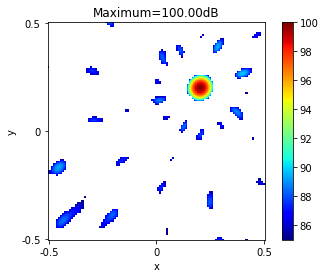

In [14]:
for i in [1000,3000,6000]:
    beamforming_multi(f=i,snapshots=1,SNR=-10,Noise=False,Denoise=False,diagonal_remove=True,source="single")

## COMBO Mircos Array

how many micros 36


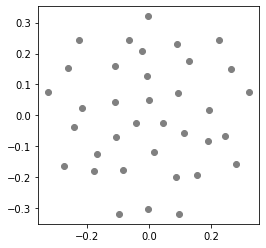

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import time

M=36
pos_x=np.array([-0.0006251,-0.1102,-0.2177,-0.3256,-0.2621,-0.2273,-0.1109,-0.007009,-0.02275,-0.06538,-0.004668,0.09016,0.043726,0.093032,0.13073,0.2273,0.26416,0.32444,0.19401,0.11462,0.19203,0.24478,0.28007,0.15428,-0.043101,0.017168,0.086966,0.098298,-0.0020581,-0.097141,-0.083114,-0.10761,-0.16928,-0.1794,-0.2754,-0.24444])
pos_y=np.array([0.05013,0.0438,0.02527,0.07448,0.1537,0.2434,0.16,0.1283,0.2086,0.2449,0.3207,0.2302,-0.024524,0.073536,0.1759,0.24474,0.15014,0.075148,0.016042,-0.05808,-0.084598,-0.065829,-0.15631,-0.19318,-0.025606,-0.11734,-0.20117,-0.31922,-0.30384,-0.31855,-0.17604,-0.07022,-0.124,-0.17907,-0.16439,-0.037019])
plt.scatter(pos_x,pos_y,c="gray")
#plt.axis('equal')
plt.axis('scaled')
pos= np.zeros([pos_x.shape[0],3])
pos[:,0]=pos_x
pos[:,1]=pos_y
print("how many micros",pos.shape[0])

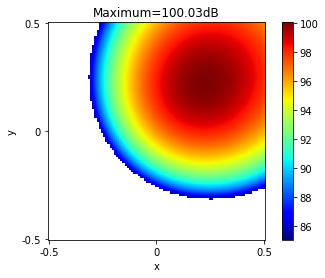

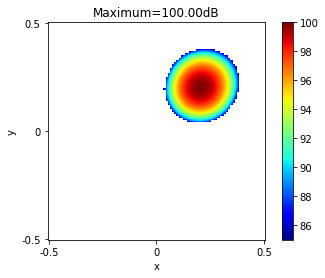

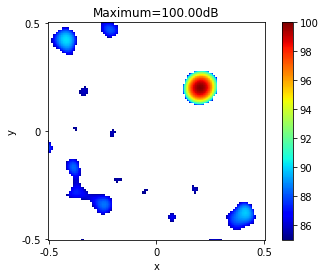

In [16]:
for i in [1000,3000,6000]:
    beamforming_multi(f=i,snapshots=1,SNR=-10,Noise=False,Denoise=False,diagonal_remove=True,source="single")

# Noise added on COMBO Micros Array

## Snapshots as Variable, f=6000Hz, Line Sources

### SNR=10dB


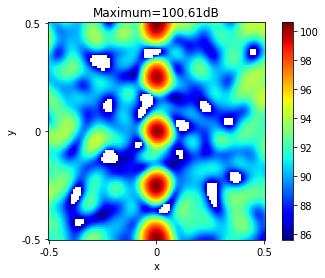

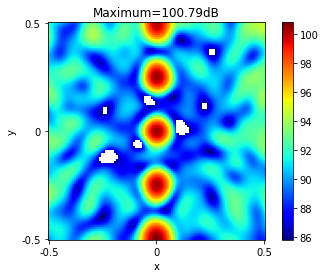

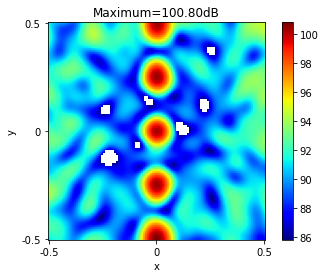

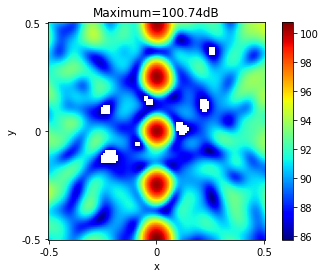

In [17]:
for i in [10**x for x in range(0,4)]:
  beamforming_multi(f=6000,snapshots=i,SNR=10,Noise=True,Denoise=False,diagonal_remove=False,source="line")

### SNR=0dB

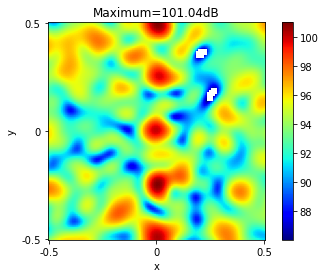

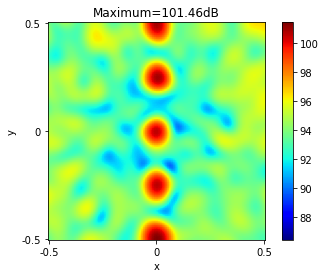

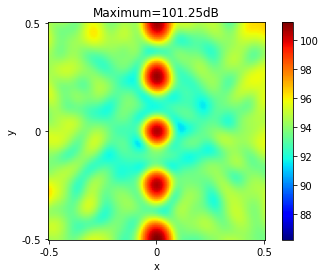

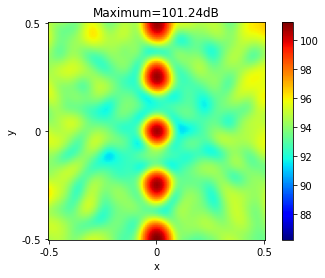

In [18]:
for i in [10**x for x in range(0,4)]:
  beamforming_multi(f=6000,snapshots=i,SNR=0,Noise=True,Denoise=False,diagonal_remove=False,source="line")

### SNR=-10dB

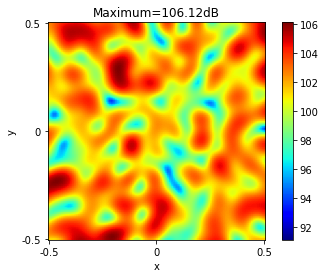

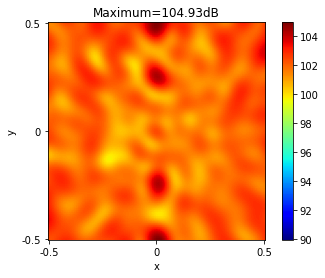

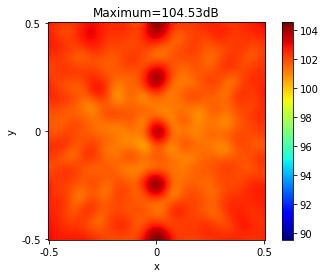

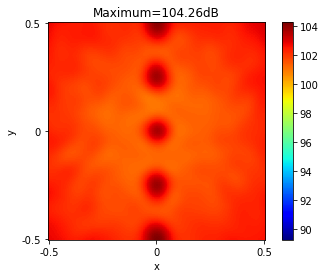

In [19]:
for i in [10**x for x in range(0,4)]:
  beamforming_multi(f=6000,snapshots=i,SNR=-10,Noise=True,Denoise=False,diagonal_remove=False,source="line")

# Denoise for noisy COMBO Micros Array

## Denoise performance when SNR=0dB, snapshots=1000

### f=3000Hz

-8.869308843471856

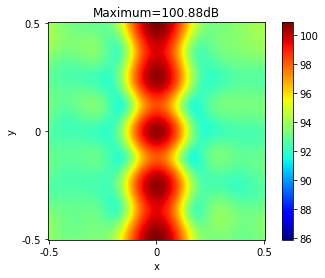

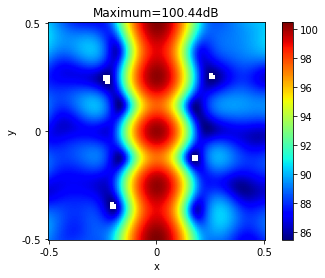

In [22]:
beamforming_multi(f=3000,snapshots=1000,SNR=0,Noise=True,Denoise=False,diagonal_remove=False,source="line")
beamforming_multi(f=3000,snapshots=1000,SNR=0,Noise=True,Denoise=True,diagonal_remove=False,source="line")

### f=6000Hz

-8.777980935343411

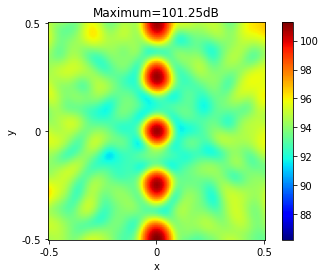

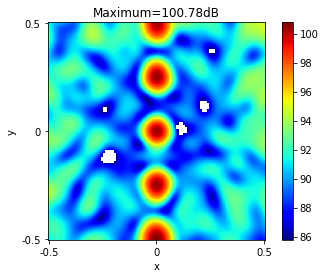

In [23]:
beamforming_multi(f=6000,snapshots=1000,SNR=0,Noise=True,Denoise=False,diagonal_remove=False,source="line")
beamforming_multi(f=6000,snapshots=1000,SNR=0,Noise=True,Denoise=True,diagonal_remove=False,source="line")

## Denoise performance when SNR=-10dB, snapshots=1000

### f=3000Hz

0.9288204309206353

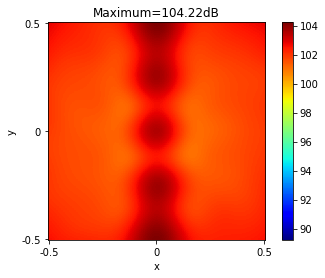

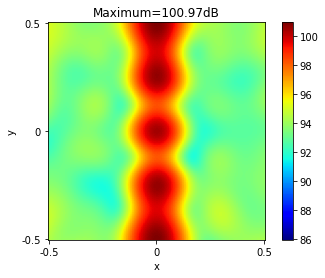

In [24]:
beamforming_multi(f=3000,snapshots=1000,SNR=-10,Noise=True,Denoise=False,diagonal_remove=False,source="line")
beamforming_multi(f=3000,snapshots=1000,SNR=-10,Noise=True,Denoise=True,diagonal_remove=False,source="line")

### f=6000Hz

0.9918376593079216

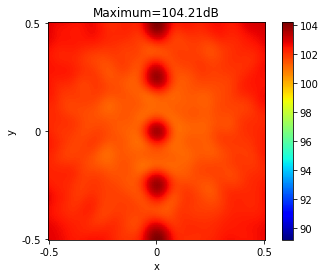

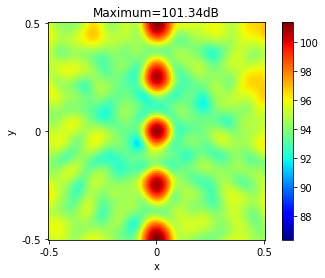

In [25]:
beamforming_multi(f=6000,snapshots=1000,SNR=-10,Noise=True,Denoise=False,diagonal_remove=False,source="line")
beamforming_multi(f=6000,snapshots=1000,SNR=-10,Noise=True,Denoise=True,diagonal_remove=False,source="line")

## Functional relationship between delta and snapshots

process= 20.0 %   snapshots= 6   time: 7.13 s
process= 40.0 %   snapshots= 54   time: 15.0 s
process= 60.0 %   snapshots= 526   time: 26.47 s
process= 80.0 %   snapshots= 5126   time: 71.63 s
process= 100.0 %   snapshots= 50000   time: 434.11 s
process= 20.0 %   snapshots= 6   time: 5.99 s
process= 40.0 %   snapshots= 54   time: 12.45 s
process= 60.0 %   snapshots= 526   time: 22.15 s
process= 80.0 %   snapshots= 5126   time: 64.75 s
process= 100.0 %   snapshots= 50000   time: 425.6 s


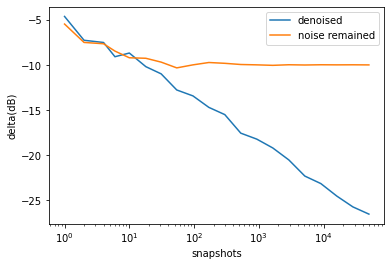

In [40]:
delta=[]
t=time.time()
sample_num=20
Snapshots=np.array([10**x for x in np.linspace(0,np.log(5*10**4)/np.log(10),sample_num)])
Snapshots=np.ceil(Snapshots).astype(np.int64)
for snapshots in Snapshots:
  current_delta=beamforming_multi(f=6000,snapshots=snapshots,SNR=10,Noise=True,Denoise=True,source="line",plot=False)
  delta.append(current_delta)
  if (np.where(Snapshots==snapshots)[0][0]+1)%(0.2*Snapshots.shape[0])==0:
    print("process=",np.round((np.where(Snapshots==snapshots)[0][0]+1)/sample_num*100,2),"%   snapshots=",snapshots,"  time:",np.round(time.time()-t,2),"s")

noisy_delta=[]
t=time.time()
for snapshots in Snapshots:
  current_noisy_delta=beamforming_multi(f=6000,snapshots=snapshots,SNR=10,Noise=True,Denoise=False,source="line",plot=False)
  noisy_delta.append(current_noisy_delta)
  if (np.where(Snapshots==snapshots)[0][0]+1)%(0.2*Snapshots.shape[0])==0:
    print("process=",np.round((np.where(Snapshots==snapshots)[0][0]+1)/sample_num*100,2),"%   snapshots=",snapshots,"  time:",np.round(time.time()-t,2),"s")

#poly = np.polyfit(Snapshots, np.array(delta), deg=5)
#y_value = np.polyval(poly, Snapshots)
plt.plot(Snapshots,np.array(delta))
plt.plot(Snapshots,np.array(noisy_delta))
plt.xscale("log") 
#plt.title("line sources")
plt.xlabel("snapshots")
plt.ylabel("delta(dB)")
plt.legend(["denoised","noise remained"])

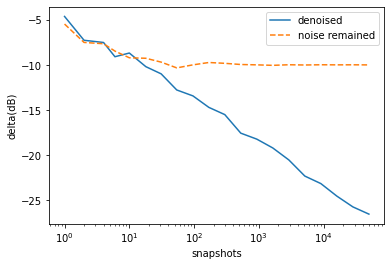

In [45]:
#set noise remained curve to dashed line"--"

plt.plot(Snapshots,np.array(delta))
plt.plot(Snapshots,np.array(noisy_delta),"--")
plt.xscale("log") 
#plt.title("line sources")
plt.xlabel("snapshots")
plt.ylabel("delta(dB)")
plt.legend(["denoised","noise remained"])

## Functional relationship between delta and SNR

SNR= -10.0   time: 5.1 s
SNR= -9.0   time: 10.17 s
SNR= -8.0   time: 15.21 s
SNR= -7.0   time: 20.3 s
SNR= -6.0   time: 25.41 s
SNR= -5.0   time: 30.52 s
SNR= -4.0   time: 35.77 s
SNR= -3.0   time: 40.95 s
SNR= -2.0   time: 46.05 s
SNR= -1.0   time: 51.18 s
SNR= 0.0   time: 56.38 s
SNR= 1.0   time: 61.6 s
SNR= 2.0   time: 66.84 s
SNR= 3.0   time: 72.1 s
SNR= 4.0   time: 77.36 s
SNR= 5.0   time: 82.63 s
SNR= 6.0   time: 88.17 s
SNR= 7.0   time: 93.45 s
SNR= 8.0   time: 98.82 s
SNR= 9.0   time: 104.42 s
SNR= 10.0   time: 109.9 s
SNR= -10.0   time: 4.89 s
SNR= -9.0   time: 9.79 s
SNR= -8.0   time: 15.05 s
SNR= -7.0   time: 19.98 s
SNR= -6.0   time: 24.9 s
SNR= -5.0   time: 29.88 s
SNR= -4.0   time: 34.8 s
SNR= -3.0   time: 39.87 s
SNR= -2.0   time: 44.94 s
SNR= -1.0   time: 49.95 s
SNR= 0.0   time: 55.02 s
SNR= 1.0   time: 60.0 s
SNR= 2.0   time: 64.87 s
SNR= 3.0   time: 69.78 s
SNR= 4.0   time: 74.67 s
SNR= 5.0   time: 79.54 s
SNR= 6.0   time: 84.39 s
SNR= 7.0   time: 89.51 s
SNR= 8.0   

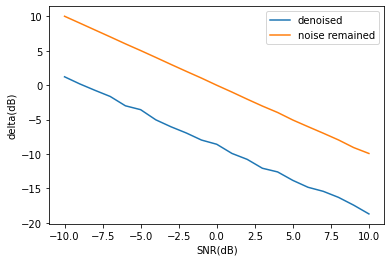

In [41]:
def plot_SNR(if_denoise):
  delta=[]
  t=time.time()
  for i in np.arange(-100,101,10)*0.1:
    current_delta=beamforming_multi(f=6000,snapshots=1000,SNR=i,Noise=True,Denoise=if_denoise,source="five",plot=False)
    delta.append(current_delta)
    if i%1==0:
      print("SNR=",i,"  time:",np.round(time.time()-t,2),"s")
  return delta
SNR_=np.arange(-100,101,10)*0.1
SNR_delta=plot_SNR(True)
SNR_noisy_delta=plot_SNR(False)
plt.plot(SNR_,np.array(SNR_delta))
plt.plot(SNR_,np.array(SNR_noisy_delta))
#plt.title("line sources")
plt.xlabel("SNR(dB)")
plt.ylabel("delta(dB)")
plt.legend(["denoised","noise remained"])

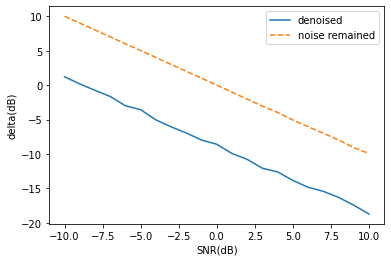

In [46]:
##set noise remained curve to dashed line"--"

plt.plot(SNR_,np.array(SNR_delta))
plt.plot(SNR_,np.array(SNR_noisy_delta),"--")
#plt.title("line sources")
plt.xlabel("SNR(dB)")
plt.ylabel("delta(dB)")
plt.legend(["denoised","noise remained"])